# Package installs

In [1]:
!pip install pytorch_lightning

     |████████████████████████████████| 527 kB 8.3 MB/s 
     |████████████████████████████████| 829 kB 55.0 MB/s 
     |████████████████████████████████| 596 kB 49.3 MB/s 
     |████████████████████████████████| 396 kB 67.7 MB/s 
     |████████████████████████████████| 952 kB 25.8 MB/s 
     |████████████████████████████████| 133 kB 74.4 MB/s 
     |████████████████████████████████| 1.1 MB 62.2 MB/s 
     |████████████████████████████████| 144 kB 74.0 MB/s 
     |████████████████████████████████| 271 kB 56.6 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=cc6259570f2f2e6f91e58ede5a2b5f18538ad90ca583955d7e9025b1ec3d255b
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successful

# Imports

In [2]:
from IPython.display import Image 
from PIL import Image, ImageDraw
from os import listdir, getcwd
from os import name
from os.path import join
from pathlib import Path
from pytorch_lightning import LightningDataModule
from skimage import color
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from xml.dom import minidom
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import shutil
import torch
import xml.etree.ElementTree as ET


# Download Dataset

In [9]:
#!gdown --id 1dpTDihAN47rSBRGn_XpEYCCcchXrxnZ0
!gdown --id 1G8tbhCHPhXKsERs9kqPPDryBL-ZjHwhu
!tar -xf /content/day_time_wildfire_v2.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1G8tbhCHPhXKsERs9kqPPDryBL-ZjHwhu
To: /content/day_time_wildfire_v2.tar.gz
100% 501M/501M [00:04<00:00, 108MB/s]


# Convert annotations into a Yolo-friendly format (XML -> txt)


In [10]:
!cp -a /content/day_time_wildfire_v2/annotations/xmls/. /content/day_time_wildfire_v2/images

In [11]:
dirs = ['/content/day_time_wildfire_v2/images']
classes = ['smoke','no_smoke'] #we use two classes even though there is only one effective class for clarity

def getImagesInDir(dir_path):
    image_list = []
    for filename in glob.glob(dir_path + '/*.jpeg'):
        image_list.append(filename)

    return image_list

def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(dir_path, output_path, image_path):
    basename = os.path.basename(image_path)
    basename_no_ext = os.path.splitext(basename)[0]

    in_file = open(dir_path + '/' + basename_no_ext + '.xml')
    out_file = open(output_path + basename_no_ext + '.txt', 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((w,h), b)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

cwd = getcwd()

for dir_path in dirs:
    full_dir_path = dir_path
    output_path = full_dir_path +'/yolo/'

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    image_paths = getImagesInDir(full_dir_path)
    list_file = open(full_dir_path + '.txt', 'w')

    for image_path in image_paths:
        list_file.write(image_path + '\n')
        convert_annotation(full_dir_path, output_path, image_path)
    list_file.close()

    print("Finished processing: " + dir_path)

Finished processing: /content/day_time_wildfire_v2/images


# Isolate images and annotations


In [12]:
images = ["/content/day_time_wildfire_v2/images/"+ x for x in os.listdir("/content/day_time_wildfire_v2/images") if x[-4:] == "jpeg" ]
annotations = ["/content/day_time_wildfire_v2/images/yolo/"+ x for x in os.listdir("/content/day_time_wildfire_v2/images/yolo")]

images.sort()
annotations.sort()

# Divide dataset into training, testing and validation

In [13]:
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

# Create the necessary folder structure for YoloV5

In [14]:
!mkdir images
!mkdir annotations
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [15]:
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [16]:
!mkdir labels
!cp -a annotations/. labels

# Clone the official Yolov5 repository

In [17]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10752, done.
remote: Total 10752 (delta 0), reused 0 (delta 0), pack-reused 10752
Receiving objects: 100% (10752/10752), 10.83 MiB | 1.91 MiB/s, done.
Resolving deltas: 100% (7434/7434), done.


# Clone and place our custom configuration files

In [18]:
!git clone https://github.com/Dauriel/h2o_wildfires.git

Cloning into 'h2o_wildfires'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 98 (delta 7), reused 54 (delta 3), pack-reused 40
Unpacking objects: 100% (98/98), done.


In [19]:
!rm "/content/yolov5/models/yolov5s.yaml"

In [20]:
!cp "h2o_wildfires/yolov5s.yaml" "/content/yolov5/models/yolov5s.yaml"
!cp "h2o_wildfires/smoke.yaml" "/content/yolov5/data"
%cd yolov5

/content/yolov5


# Training

- Image size of 640x640px
- Batch size of 32
- 100 epochs

In [21]:
!python train.py --img 640 --cfg yolov5s6.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 100 --data smoke.yaml --weights yolov5s.pt --workers 24 --name yolo_smoke

train: weights=yolov5s.pt, cfg=yolov5s6.yaml, data=smoke.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_smoke, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, tra

# Inference

We use the best checkpoint to generate predictions over the unseen testing set.

The best checkpoint is located in /content/yolov5/runs/train/yolo_smoke/weights/best.pt

We use a standard threshold of 0.25

In [22]:
!python detect.py --source /content/images/test --weights /content/yolov5/runs/train/yolo_smoke/weights/best.pt --conf 0.25 --name yolo_smoke

detect: weights=['/content/yolov5/runs/train/yolo_smoke/weights/best.pt'], source=/content/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_smoke, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 280 layers, 12312052 parameters, 0 gradients
image 1/220 /content/images/test/ckagzooovqkqj0728l6zan0yk.jpeg: 512x640 1 smoke, Done. (0.014s)
image 2/220 /content/images/test/ckahefn6xf2sz0918qilabaa1.jpeg: 512x640 1 smoke, Done. (0.015s)
image 3/220 /content/images/test/ckakcchr3826v0853z3fykmjm.jpeg: 512x640 1 smoke, Done. (0.009s)
image 4/220 /content/images/test/ckakkhvg6bi6407141b

# Results

This cell can be run to display one of the resulting predicted images at random

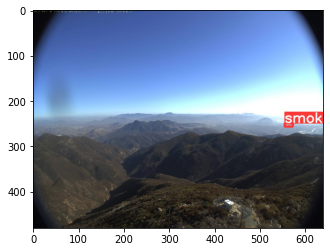

In [23]:
detections_dir = "/content/yolov5/runs/detect/yolo_smoke"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [24]:
from google.colab import files
files.download('/content/yolov5/runs/train/yolo_smoke/weights/best.pt') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model metrics

### F1 score

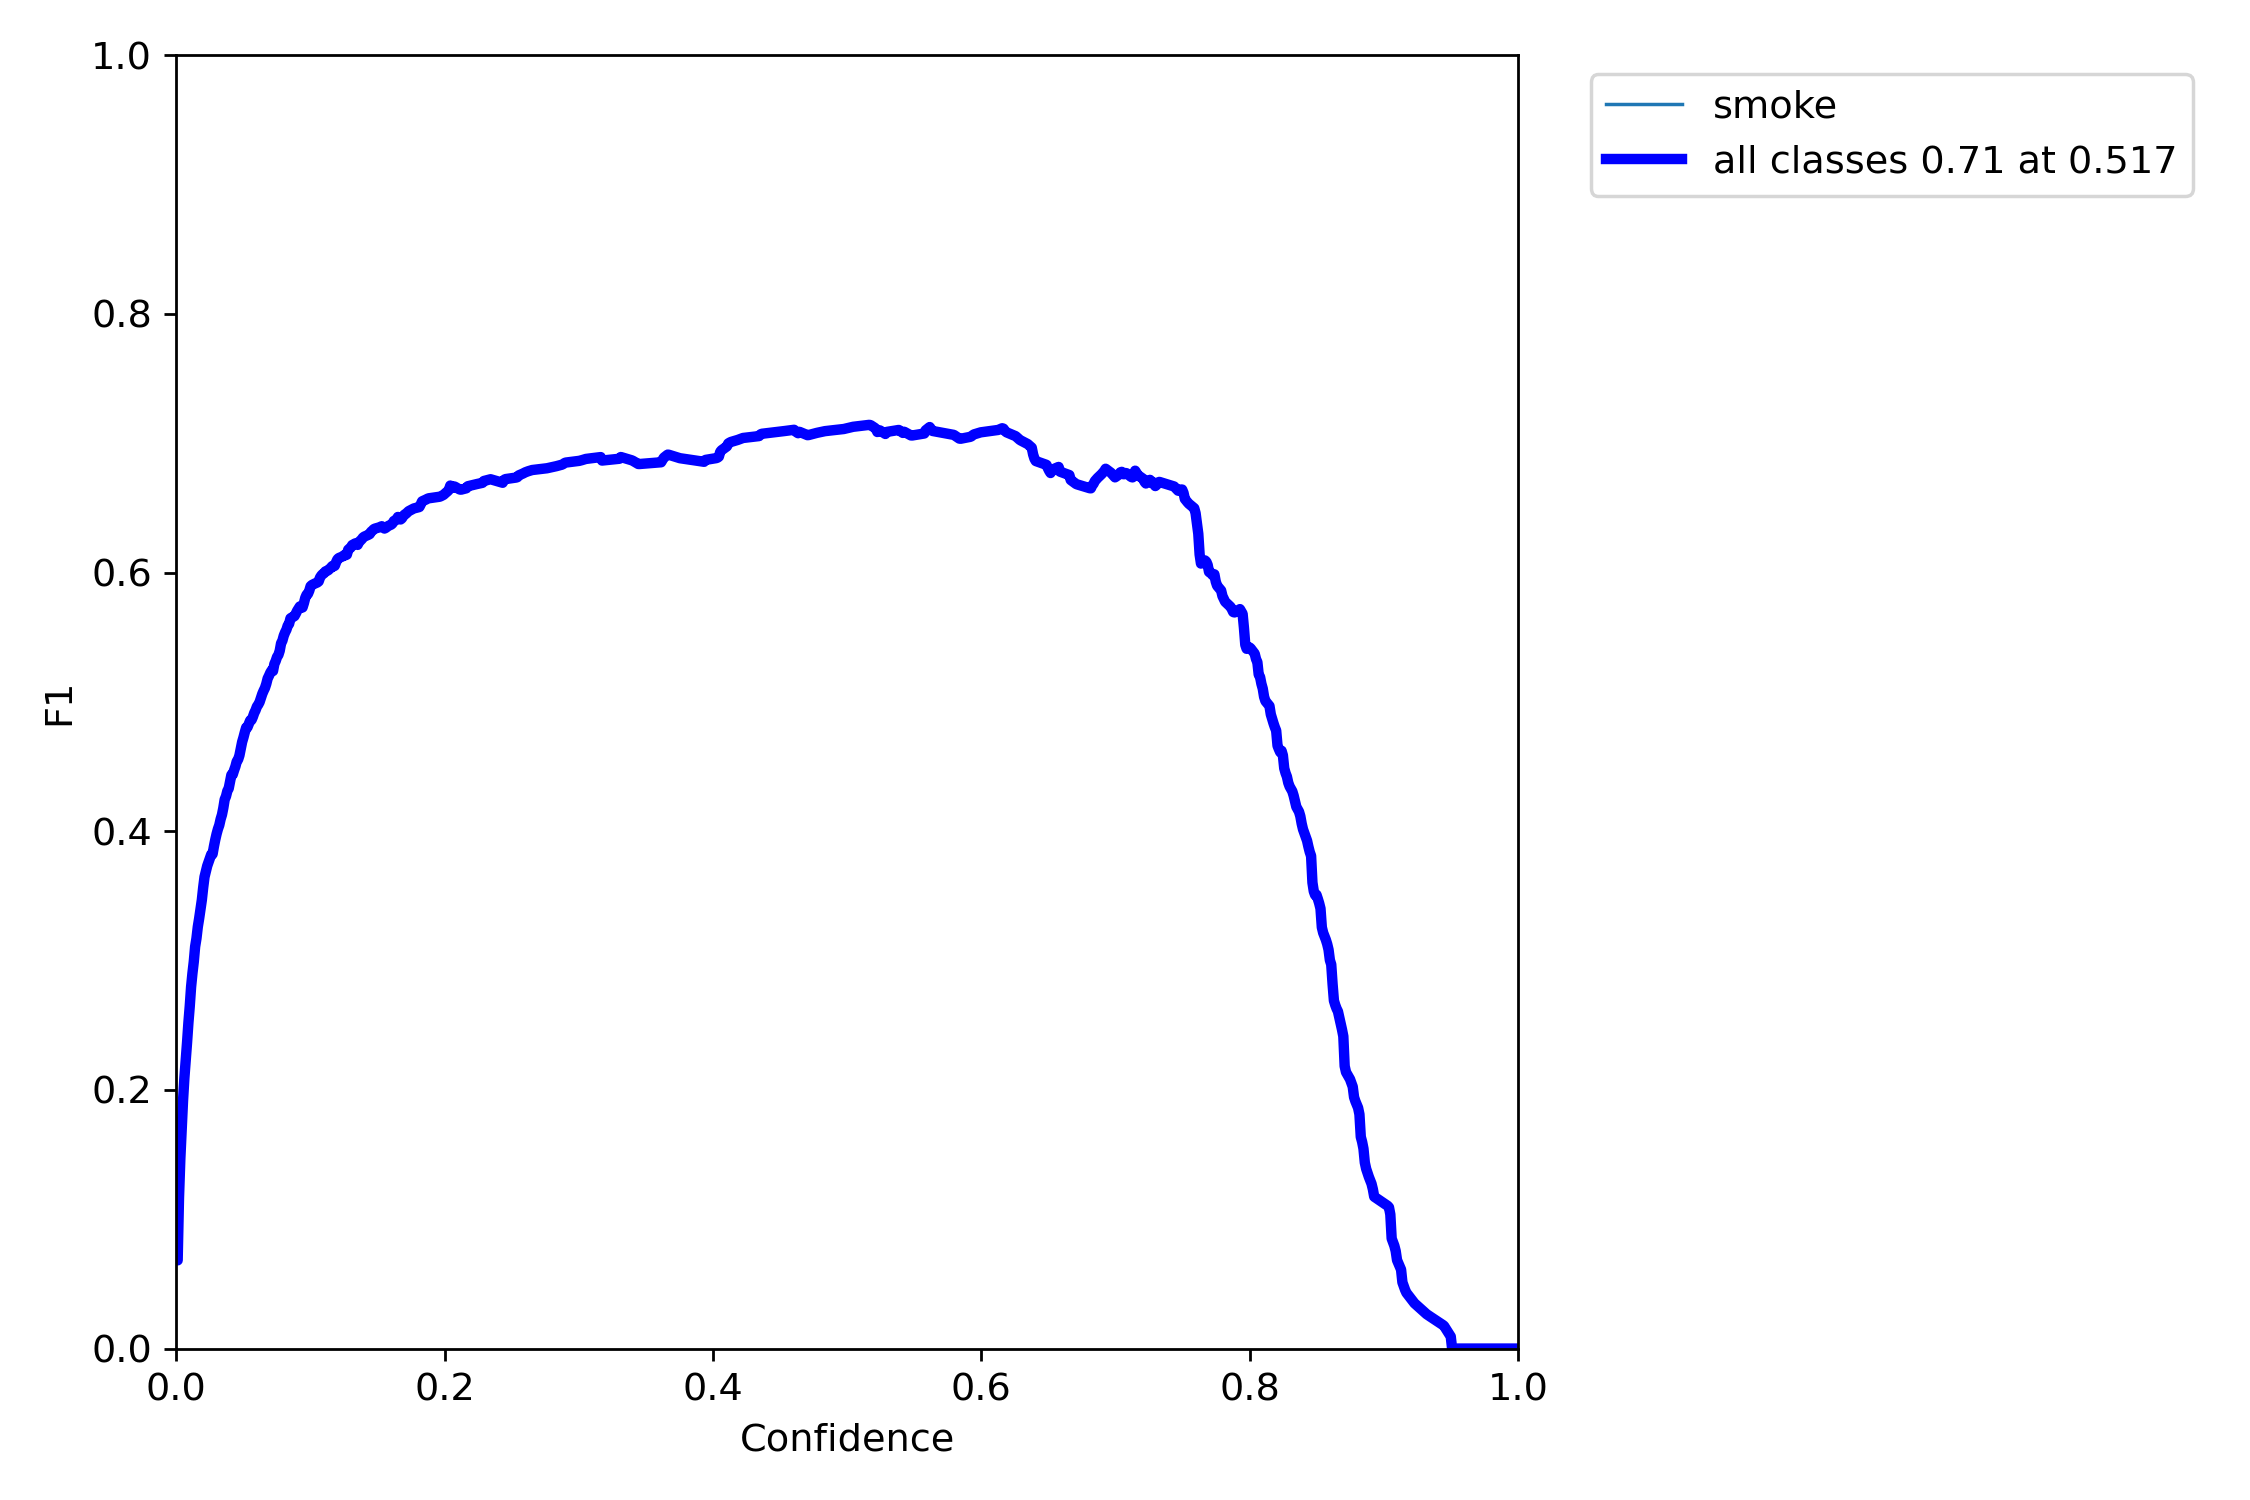

In [29]:
from IPython.display import Image
Image('/content/yolov5/runs/train/yolo_smoke/F1_curve.png', width = 700, height = 500)

### Precision

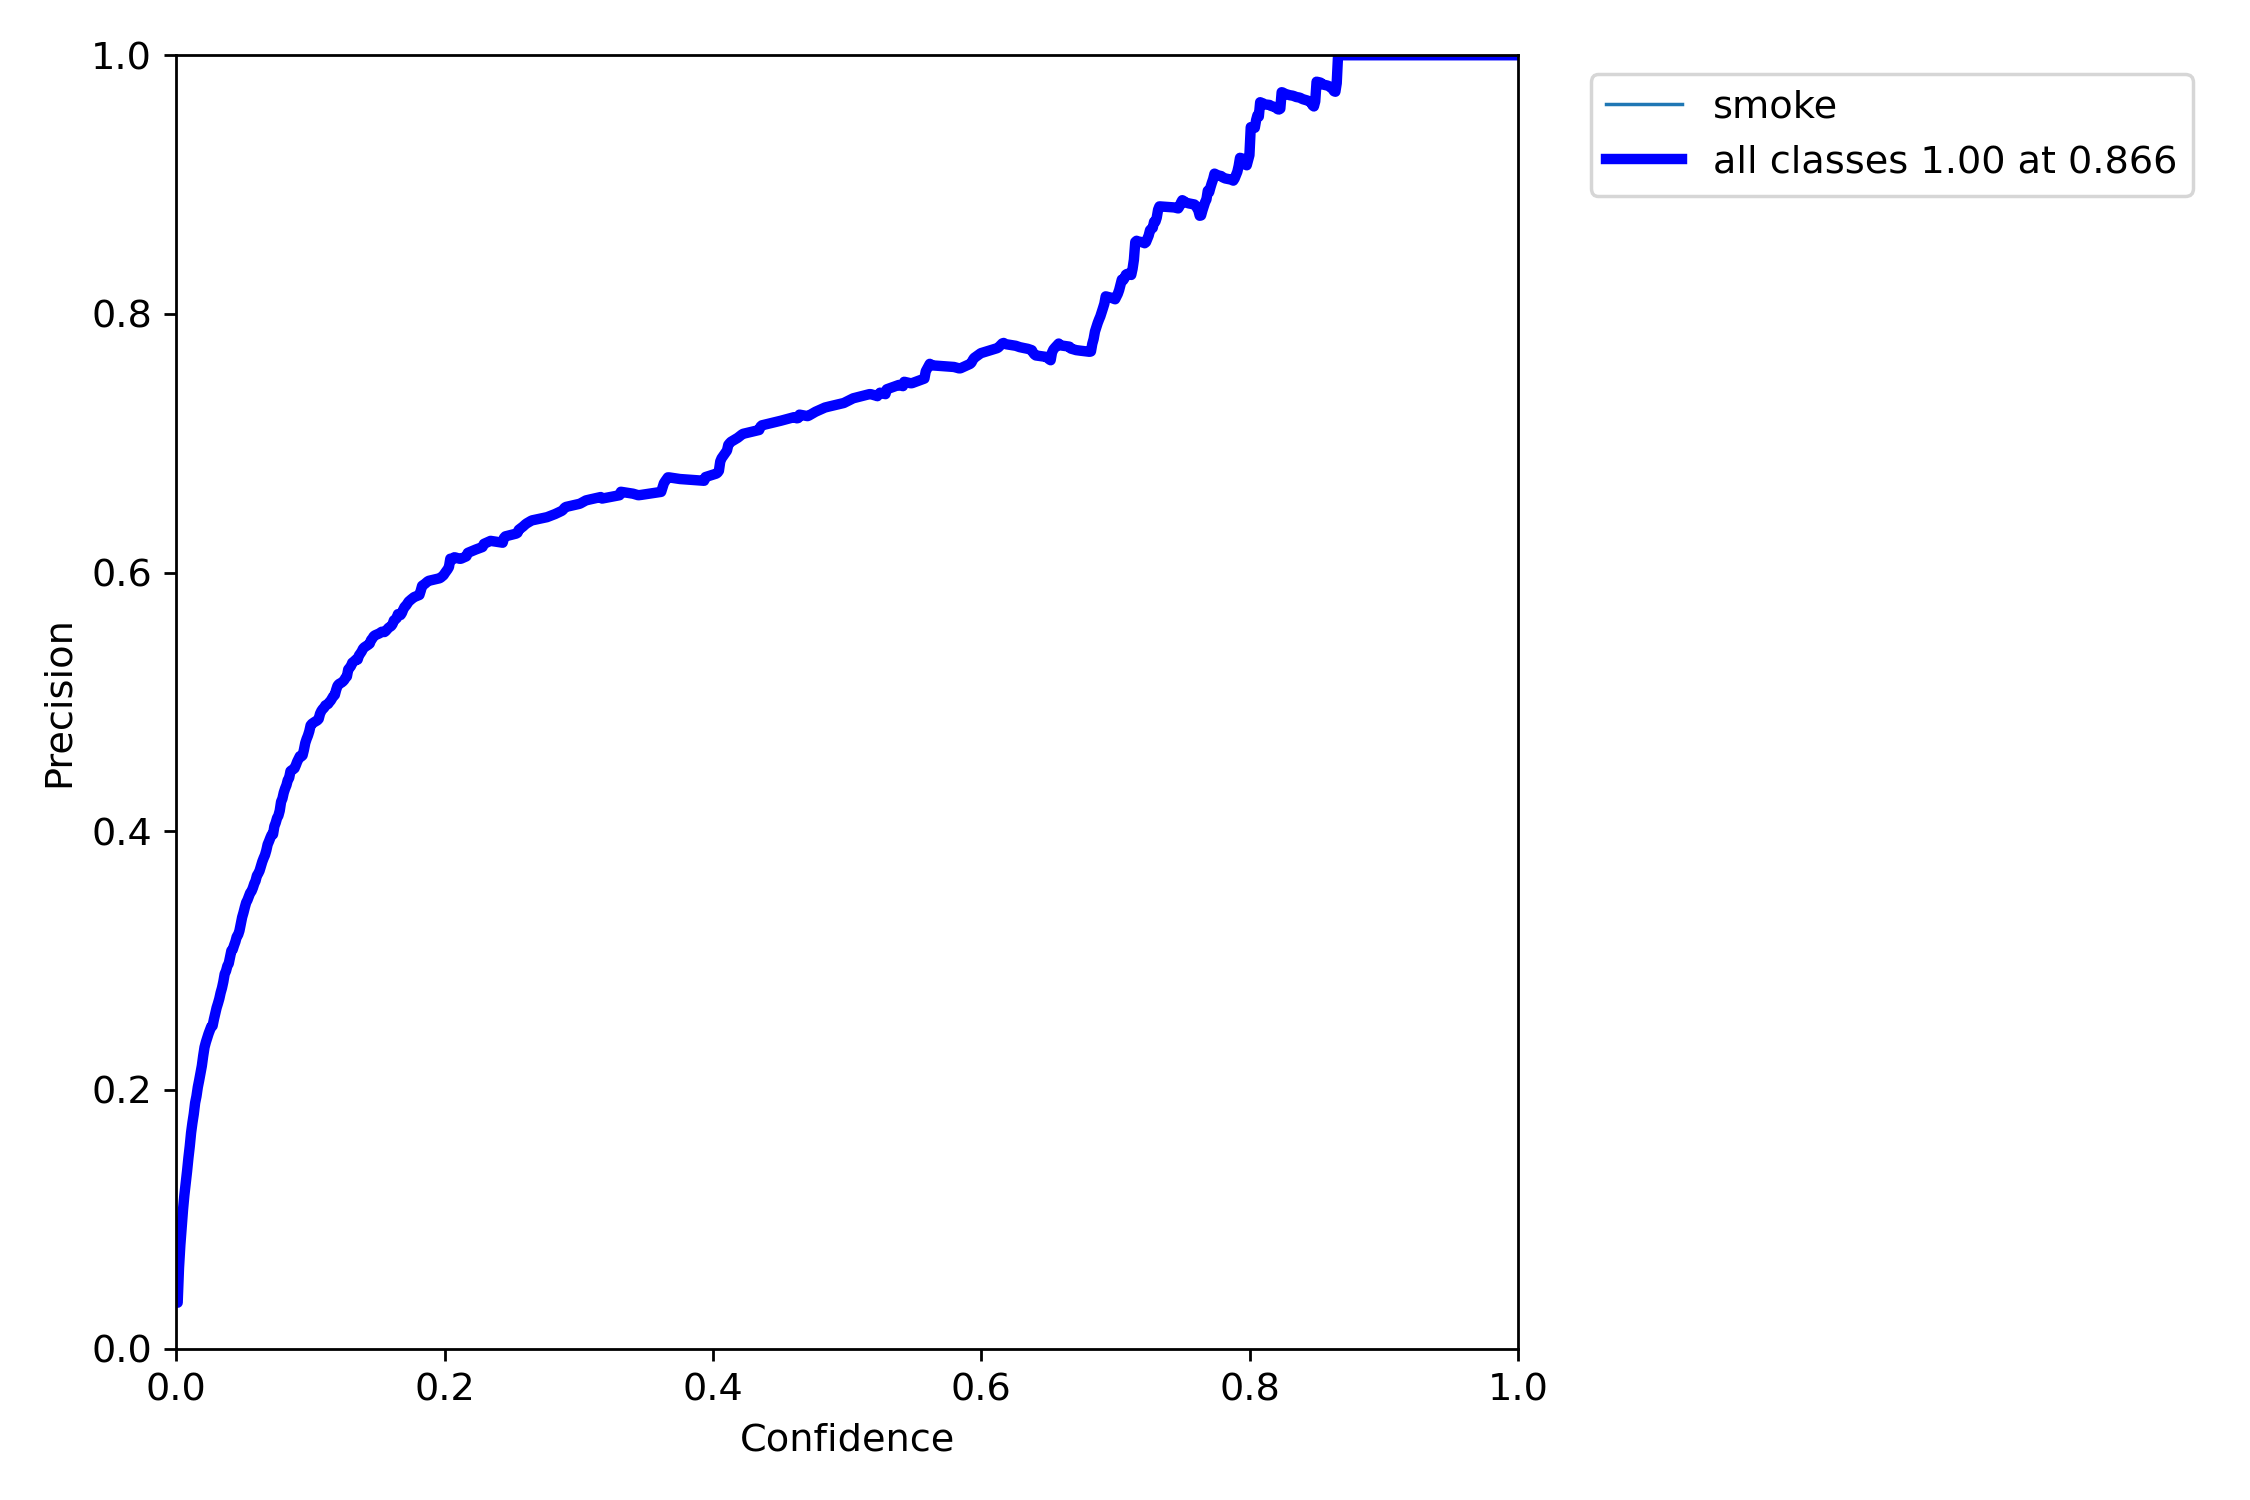

In [30]:
Image('/content/yolov5/runs/train/yolo_smoke/P_curve.png', width = 700, height = 500)

### Recall

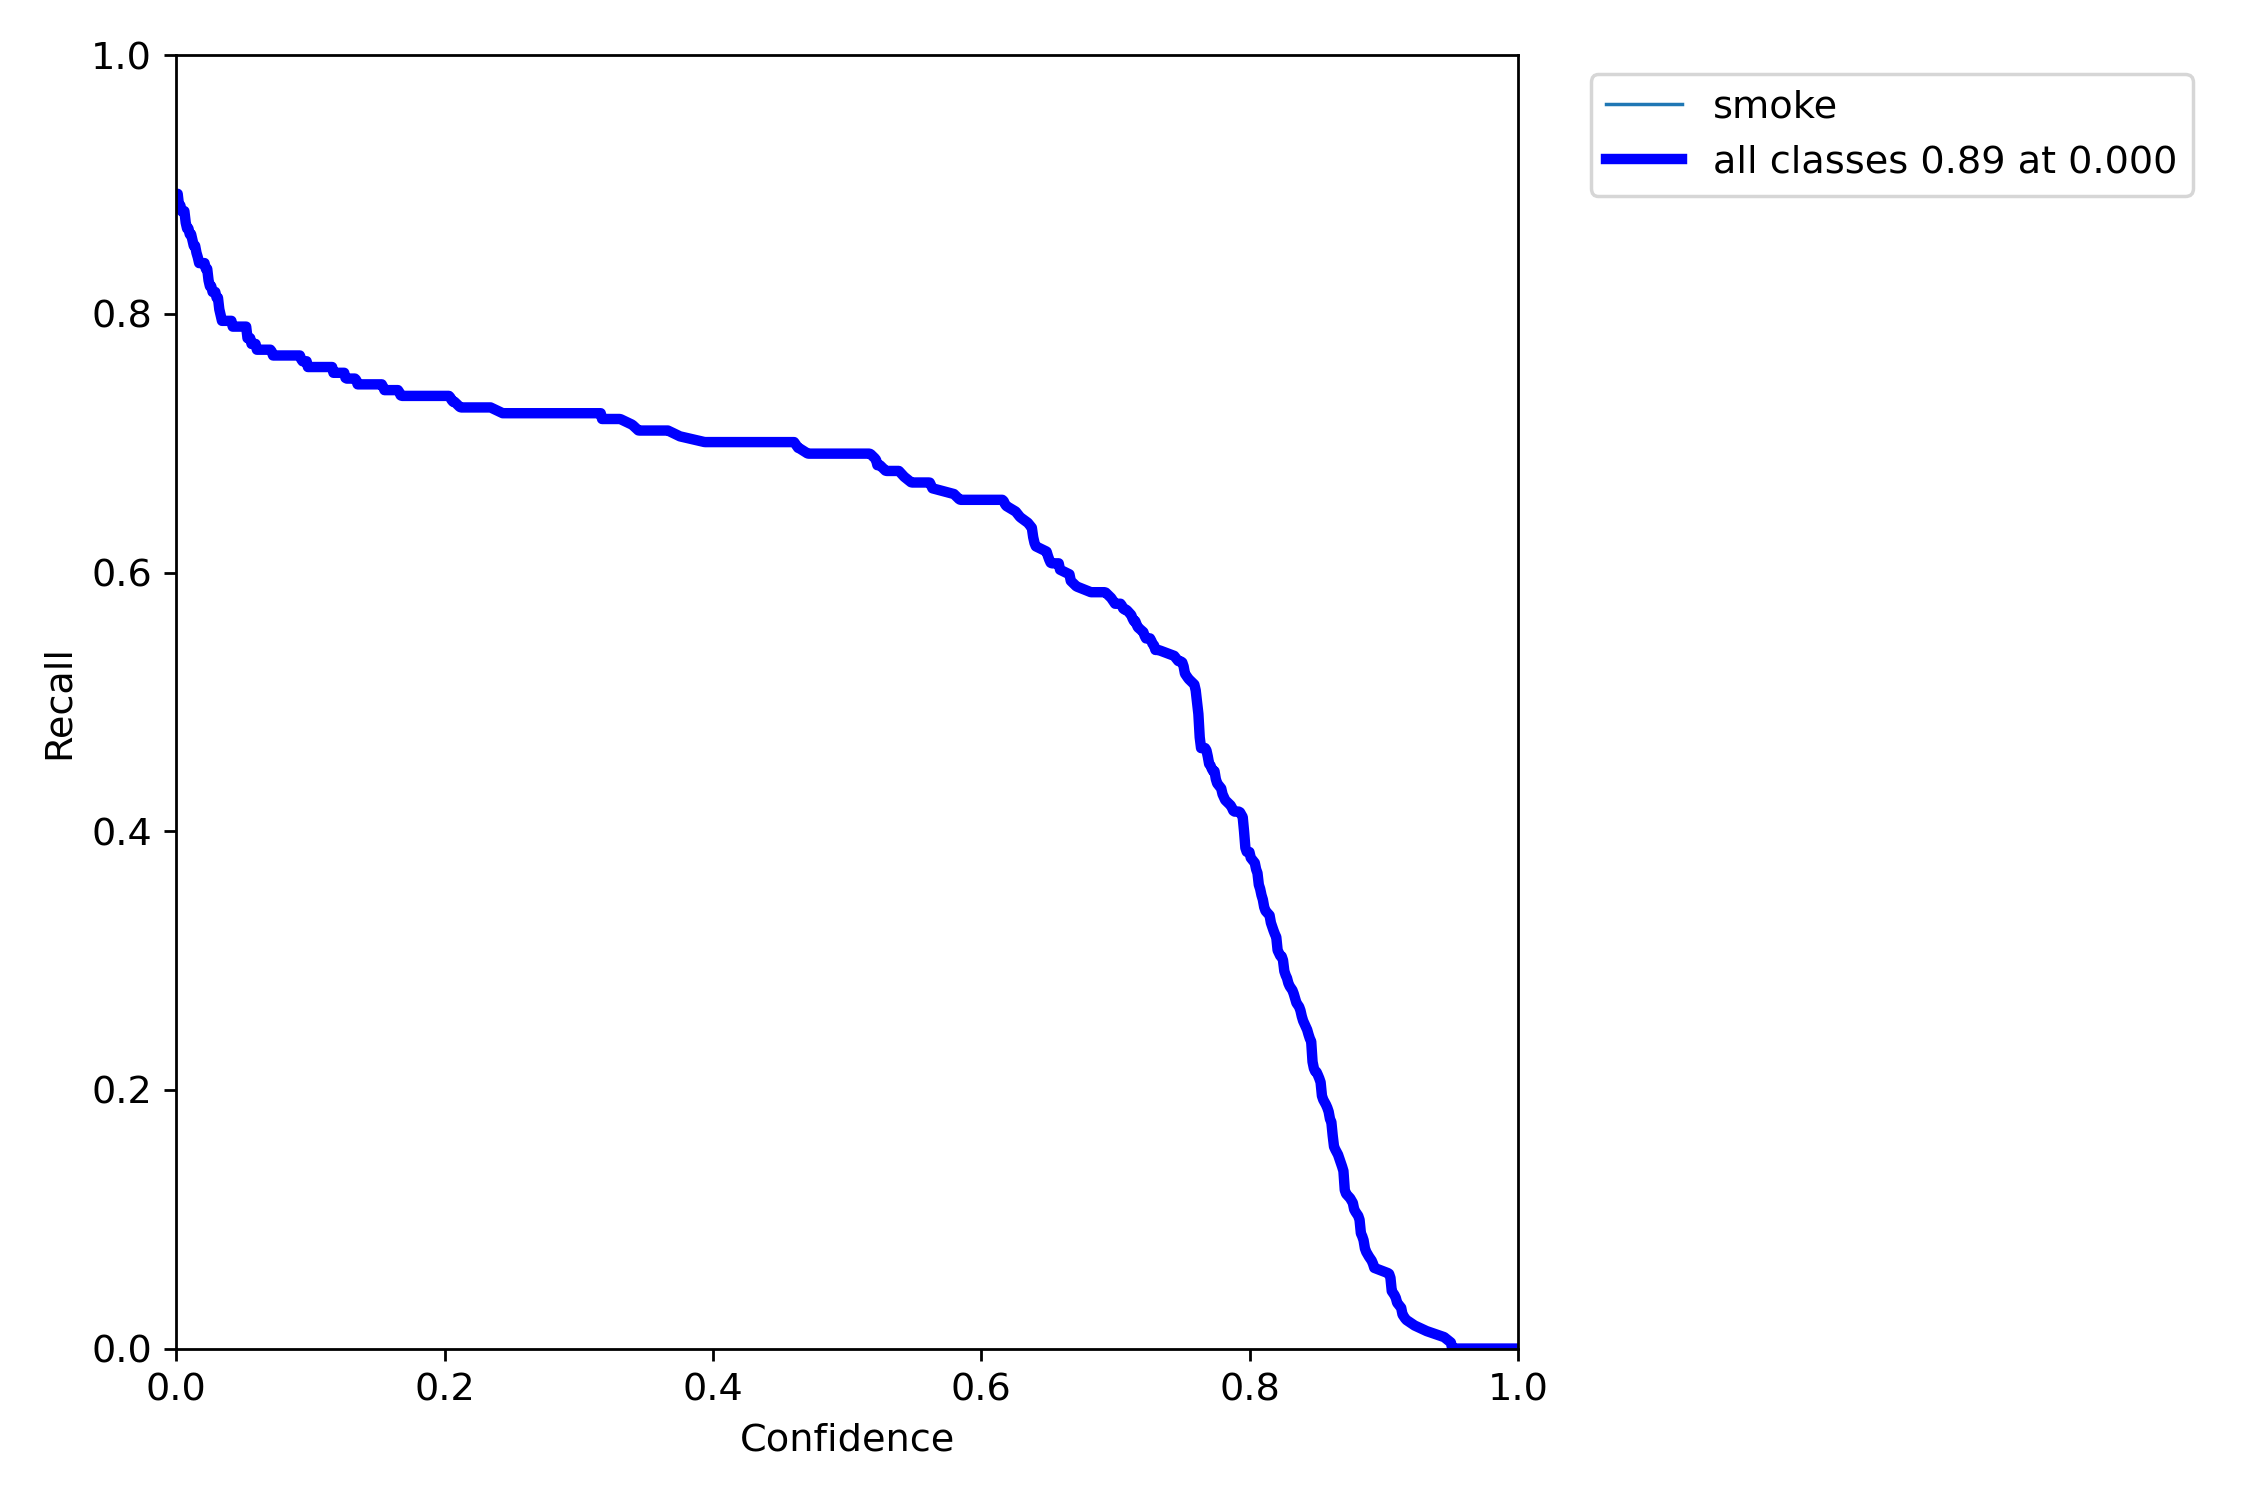

In [31]:
Image('/content/yolov5/runs/train/yolo_smoke/R_curve.png', width = 700, height = 500)

### Mean Average Precision (mAP)

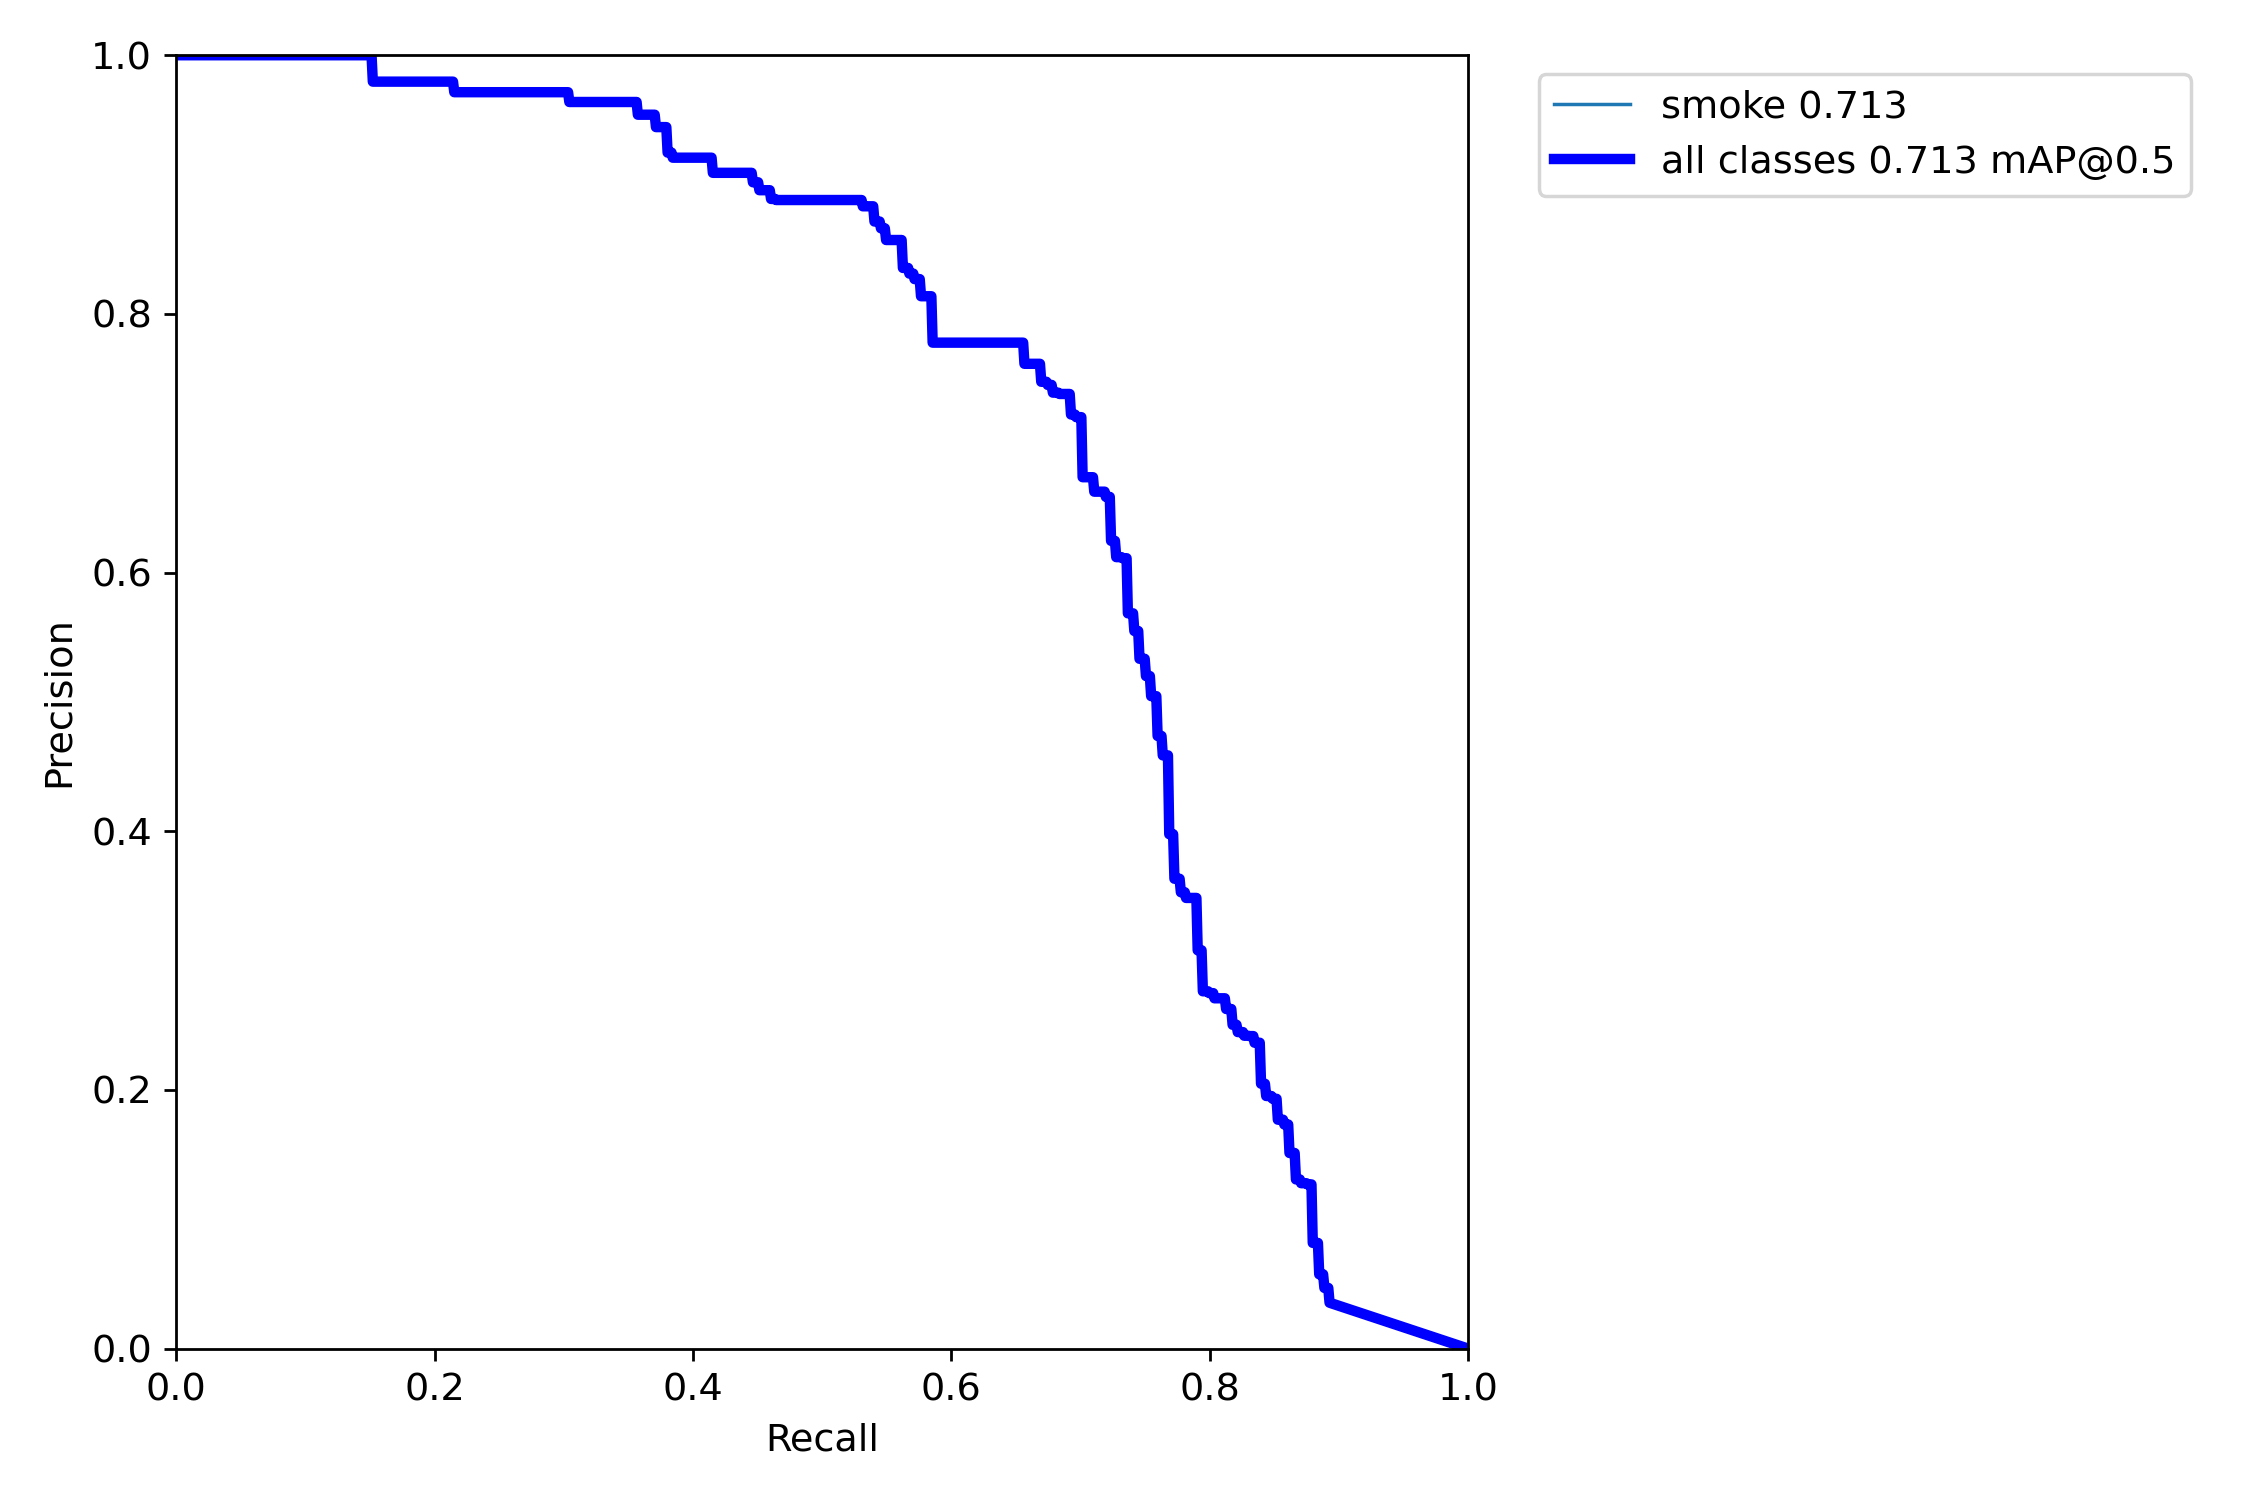

In [32]:
Image('/content/yolov5/runs/train/yolo_smoke/PR_curve.png', width = 700, height = 500)

### Results

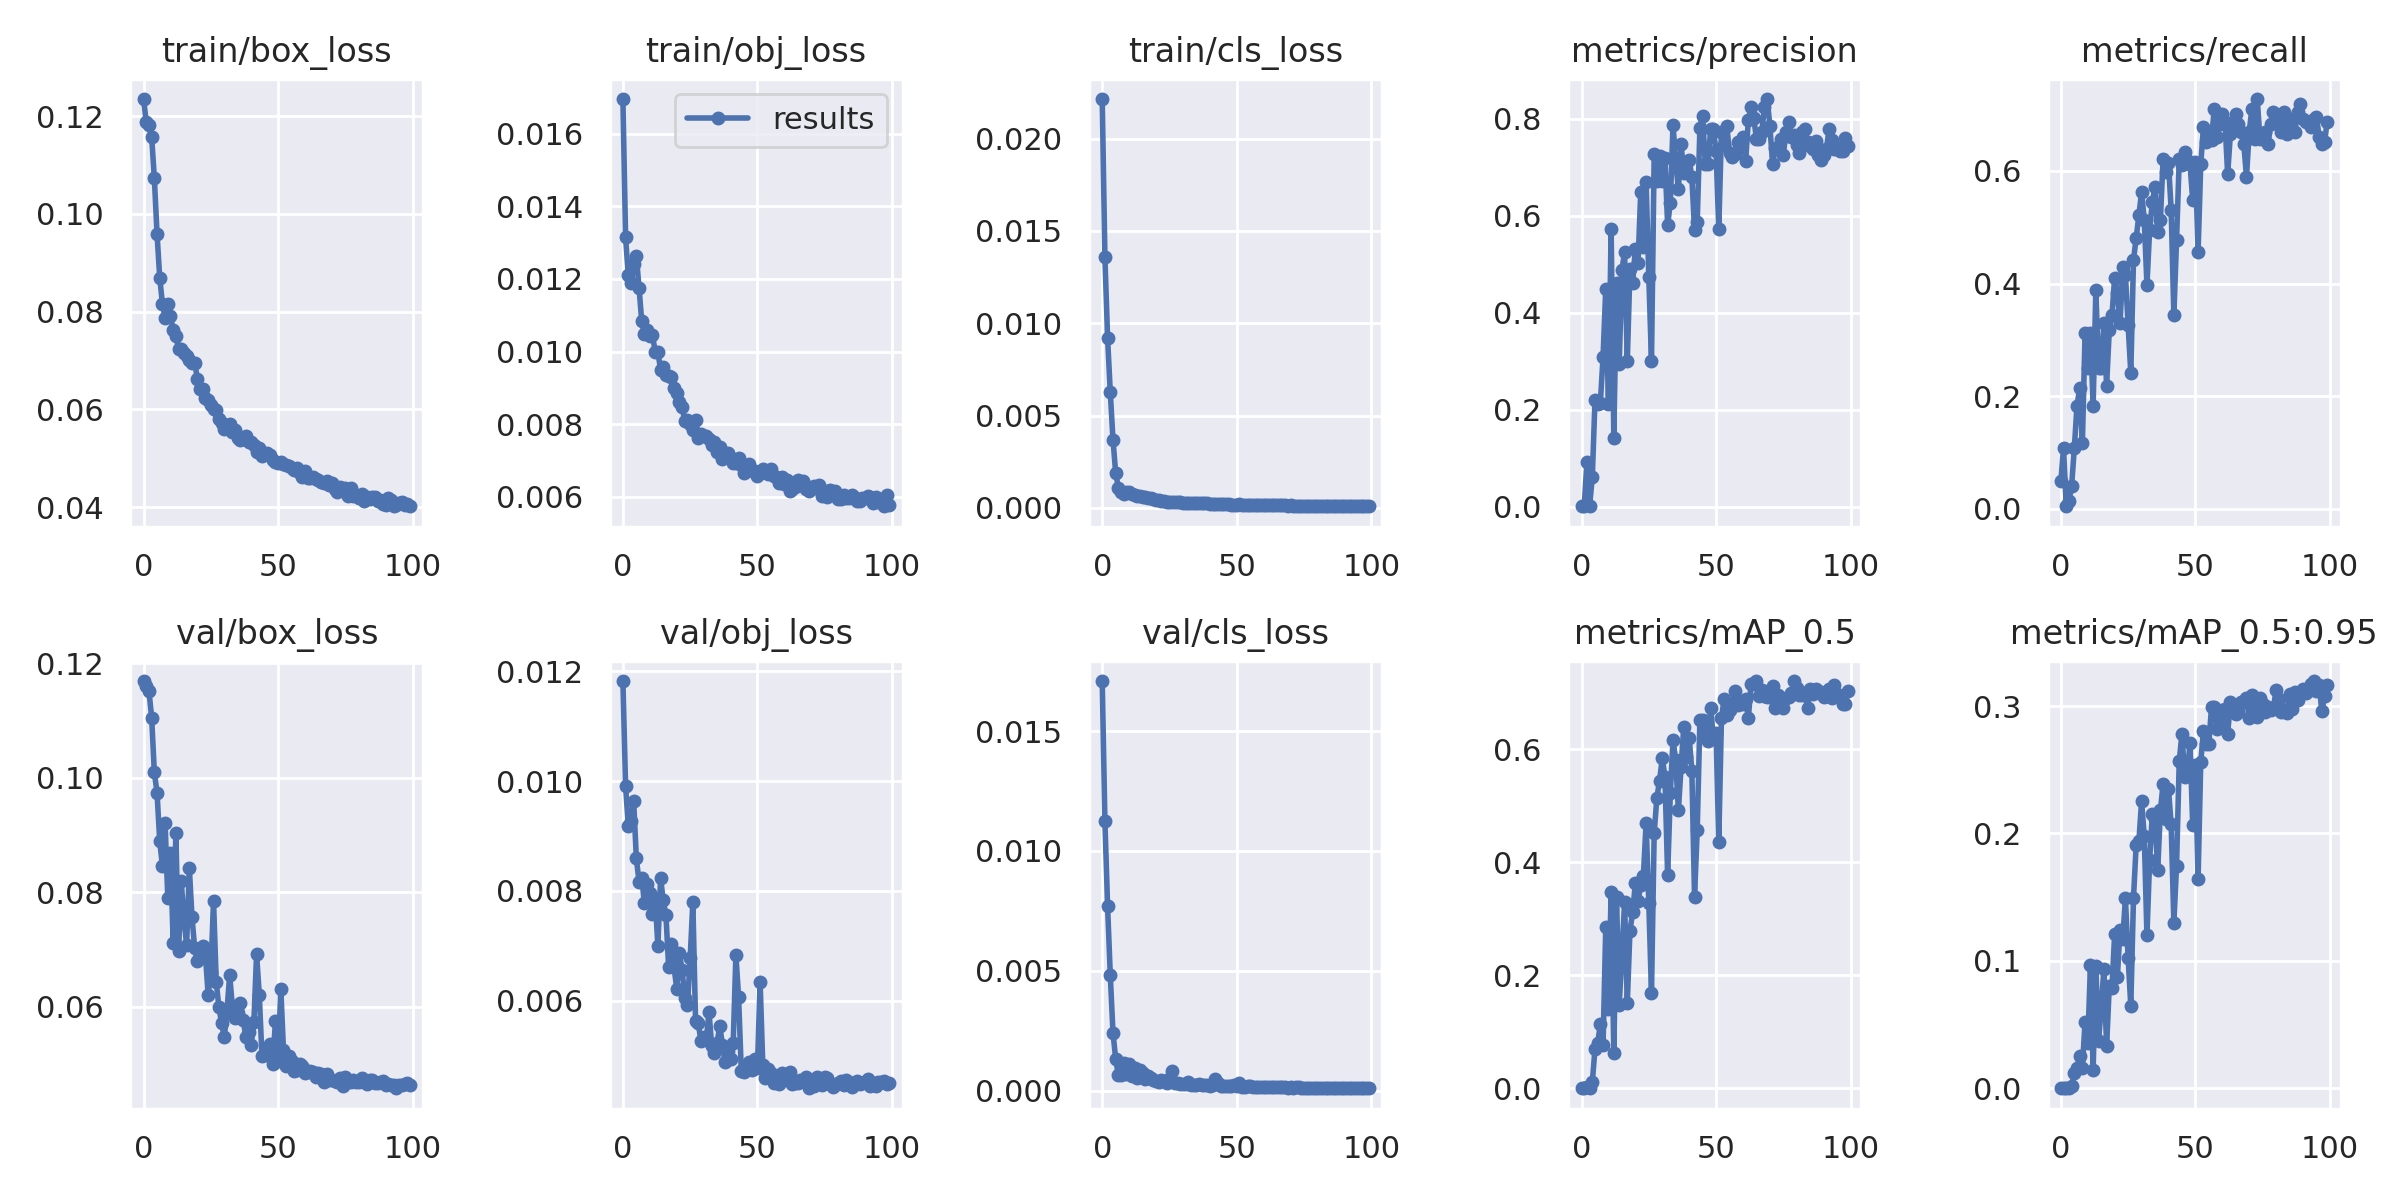

In [37]:
Image('/content/yolov5/runs/train/yolo_smoke/results.png', width = 1350, height = 720)